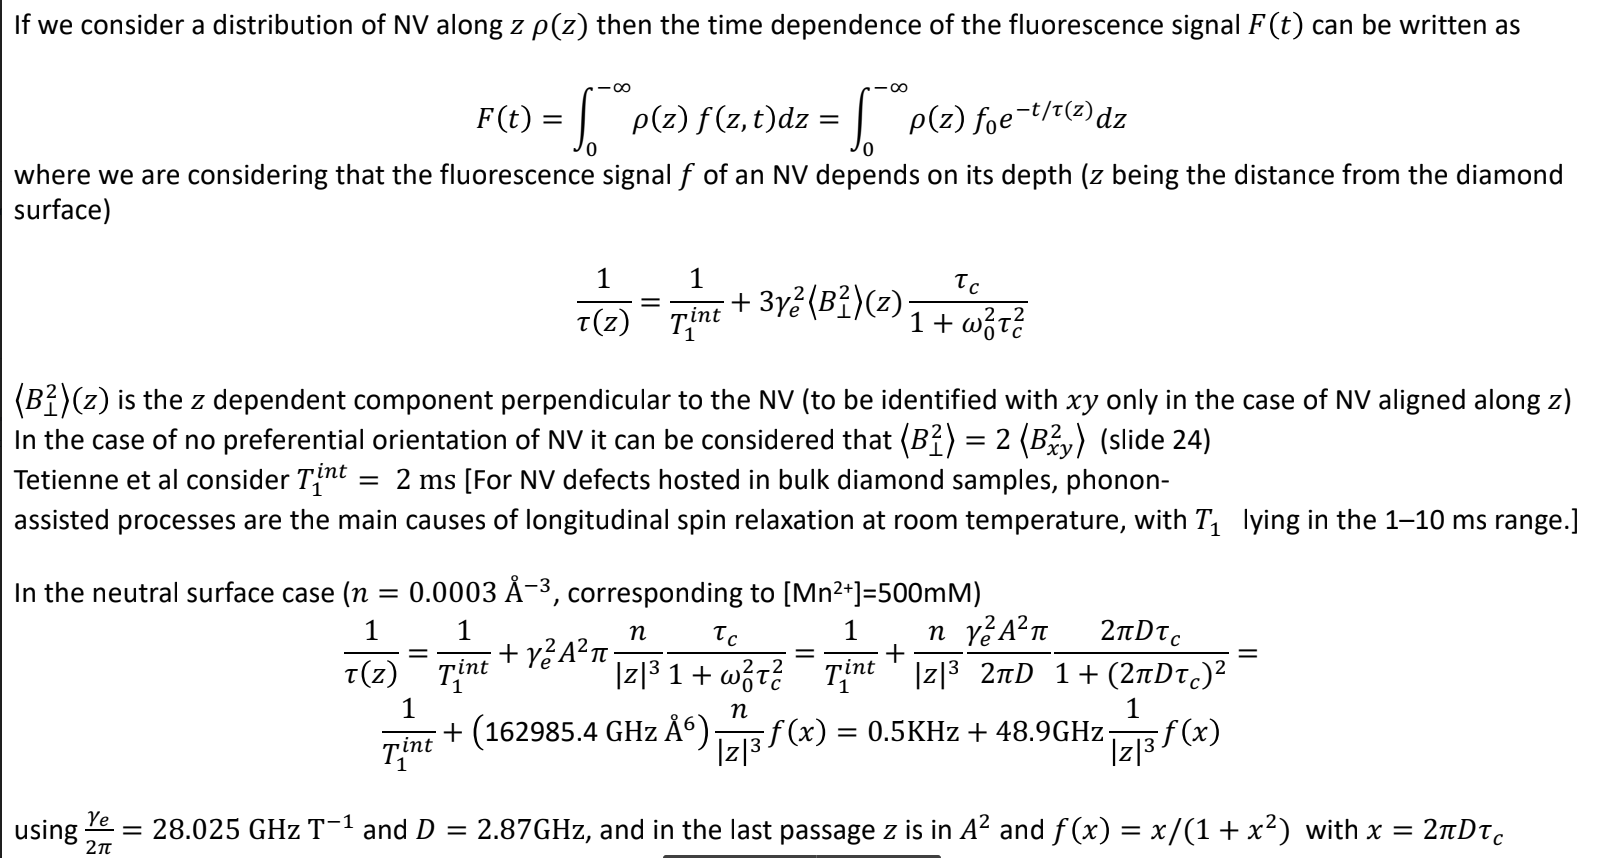

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's begin by defining $\rho(z)$.

From Justas's mail: 
"The average depth of NVs can be estimated by simulating N ions penetration depth with SRIM-2013, which is a simple tool to use. 
I did a quick simulation (see attached files) for you and for 4keV you get a mean range of 6.6nm and sigma=2.7nm.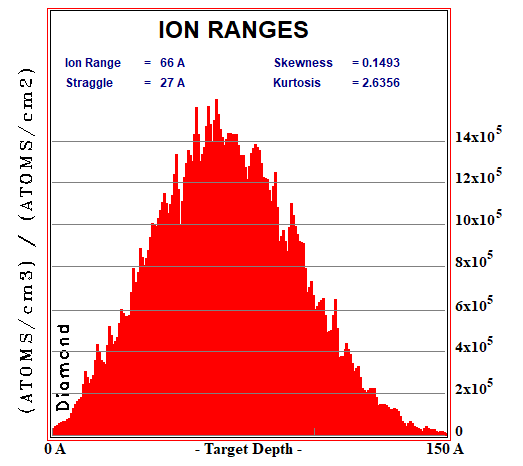"

In [2]:
# Default values are in ns.
def gaussian(x, mu = 6.6, sig = 2.7):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

Text(0, 0.5, 'rho(z)')

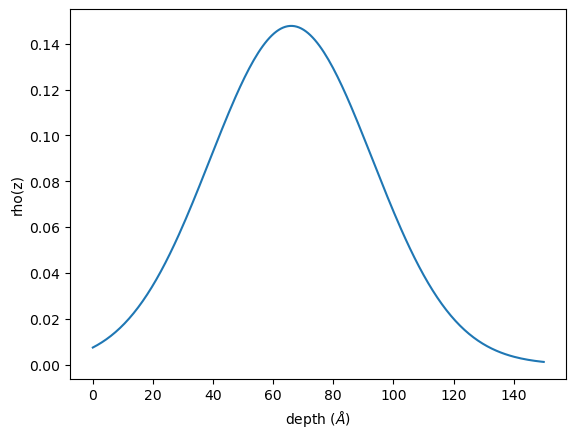

In [9]:
x_values = np.linspace(0, 15, 200)
plt.plot(x_values*10, gaussian(x_values))
plt.xlabel("depth ($\AA$)")
plt.ylabel("rho(z)")

Now let's define $1/\tau(z)$...
$$
\frac{1}{\tau(z)}=\frac{1}{T_1^{i n t}}+\gamma_e^2 A^2 \pi \frac{n}{|z|^3} \frac{\tau_c}{1+\omega_0^2 \tau_c^2}=\frac{1}{T_1^{i n t}}+\frac{n}{|z|^3} \frac{\gamma_e^2 A^2 \pi}{2 \pi D} \frac{2 \pi D \tau_c}{1+\left(2 \pi D \tau_c\right)^2}
$$
Tetienne et al consider $T_1^{int}= 2$ ms [For NV defects hosted in bulk diamond samples, phonon-
assisted processes are the main causes of longitudinal spin relaxation at room temperature, with T_1 lying in the 1–10 ms range.]


=> $1/T_1^{int} = 1/(2ms) = 0.5*10^3 Hz$

In [4]:
A = -5.492940828862188
gamma_e = 176.0810   # GHz T^-1
D = 2.87         #GHz
def one_over_tau(z, *,tau_c, n, one_over_T_1_int = .5e-3):
    return one_over_T_1_int +  (n/z**3) * ((gamma_e**2)*(A**2)*np.pi)*tau_c/(1+(2*np.pi*D*tau_c)**2)

In [5]:
# Neutral case
n = 0.0003 # Å^-3

In [6]:
n*((gamma_e**2)*(A**2)*np.pi)/(2*np.pi*D)        # GHz

48.89271968236864

Text(0.5, 0, '$z$')

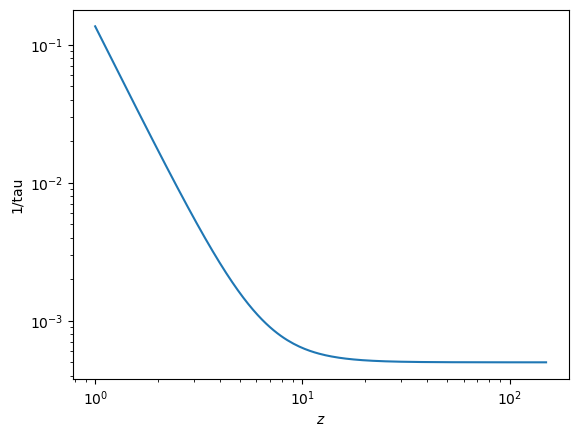

In [7]:
z_values = np.linspace(1, 150, 500)
plt.plot(z_values, one_over_tau(z_values, tau_c = 20, n = n))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('1/tau')
plt.xlabel('$z$')

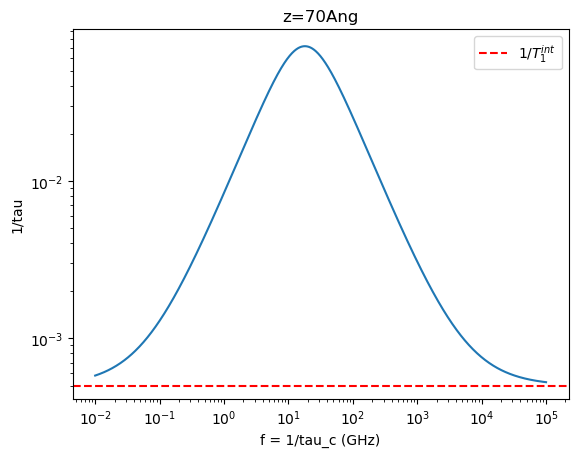

In [10]:
f_values = np.logspace(-2, 5, 1000)
plt.plot(f_values, one_over_tau(z = 7, tau_c = 1/f_values, n = n))
plt.title('z=70Ang')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('1/tau')
plt.xlabel('f = 1/tau_c (GHz)')
plt.axhline(y = .5e-3, color = 'r', linestyle = '--', label='$1/T_1^{int}$')
plt.legend()

$$
F(t)=\int_0^{-\infty} \rho(z) f(z, t) d z=\int_0^{-\infty} \rho(z) f_0 e^{-t / \tau(z)} d z
$$
Now that we have $\rho(z)$ and $1/\tau(z)$ let's define the integrand and integrate!

In [23]:
def integrand(z, t=1, *, mu = 6.6, sig = 2.7, tau_c, n, one_over_T_1_int = .5e-3):
    rho_ = gaussian(z, mu=mu, sig=sig)
    one_over_tau_ = one_over_tau(z = z, tau_c = tau_c, n = n, one_over_T_1_int = one_over_T_1_int)
    return rho_* f_0 * np.exp(-t * one_over_tau_)

0.13750153207626786


Text(0.5, 0, 'z ($\\AA$)')

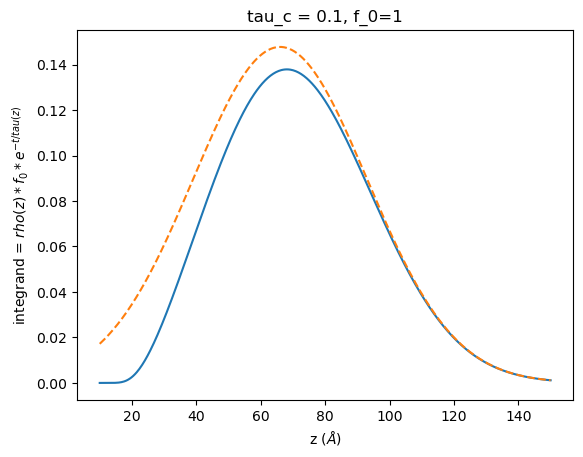

In [38]:
f_0 = 1
tau_c = .1
print(integrand(7, tau_c=tau_c, n=n))
z_values = np.linspace(1, 15, 500)
plt.title(f'tau_c = {tau_c}, f_0={f_0}')
plt.plot(z_values*10, integrand(z_values, tau_c=tau_c, n=n))
plt.plot(z_values*10, gaussian(z_values), label='rho', linestyle='--')
plt.ylabel('integrand = $rho(z)* f_0* e^{-t / tau(z)}$')
plt.xlabel('z ($\AA$)')

In [25]:
from scipy.integrate import simpson

In [33]:
simpson(integrand(z_values, tau_c=tau_c, n=n), z_values)

0.8287660726883922